In [ ]:
pip install xgboost

In [2]:
import csv
import random
import numpy as np
import datetime as dt
import zipfile

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier


def combined_csv_to_lists(csv_path):
    """
    Parameters
    ----------
    csv_path : str
        Path to the combined CSV with columns:
        comment, timestamp, day, hour, viral

    Returns
    -------
    comments   : list[str]
    timestamps : list[int]
    days       : list[int]
    hours      : list[int]
    labels     : list[int]
    """
    comments = []
    timestamps = []
    days = []
    hours = []
    labels = []

    with open(csv_path, "r", encoding="utf-8", newline="") as f:
        reader = csv.DictReader(f)

        for row in reader:
            try:
                comment = row["comment"].strip()
                ts = int(row["timestamp"])
                day = int(row["day"])
                hour = int(row["hour"])
                label = int(row["viral"])
            except (KeyError, ValueError):
                # skip rows with missing/invalid data
                continue

            comments.append(comment)
            timestamps.append(ts)
            days.append(day)
            hours.append(hour)
            labels.append(label)

    return comments, timestamps, days, hours, labels

In [4]:
import numpy as np

# Load raw data
texts, timestamps, days, hours, labels = combined_csv_to_lists('dataset.csv')

# Convert everything to numpy arrays (except texts, which stay as list of strings)
y = np.array(labels, dtype=int)
timestamps = np.array(timestamps, dtype=int)
days = np.array(days, dtype=int)
hours = np.array(hours, dtype=int)

# texts remains a list[str], which is what TfidfVectorizer expects

In [5]:
X_train_texts, X_test_texts, \
X_train_timestamps, X_test_timestamps, \
X_train_days, X_test_days, \
X_train_hours, X_test_hours, \
y_train, y_test = train_test_split(
    texts,
    timestamps,
    days,
    hours,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
import numpy as np

# Vectorize text on TRAIN, transform on TEST
vectorizer = TfidfVectorizer(
    max_features=50000,      # cap vocab size
    ngram_range=(1, 2),      # unigrams + bigrams
    min_df=2,                # ignore very rare words
    stop_words=None
)

X_train_text = vectorizer.fit_transform(X_train_texts)
X_test_text  = vectorizer.transform(X_test_texts)

# BIN timestamps into semantic ranges

# Convert to 2D arrays for processing
X_train_ts_2d = np.asarray(X_train_timestamps, dtype=float).reshape(-1, 1)
X_test_ts_2d  = np.asarray(X_test_timestamps,  dtype=float).reshape(-1, 1)

# Define bin edges (seconds):
bin_edges = np.array([
    -1e18,      # bucket 0: negative timestamps (before premiere)
    0,          # bucket 1: 0–1h
    3600,       # bucket 2: 1–24h
    86400,      # bucket 3: 1–7d
    604800,     # bucket 4: 7–30d
    2592000     # bucket 5: >30d
])

# Digitize timestamps into bins (integer indices)
X_train_bins = np.digitize(X_train_ts_2d.ravel(), bin_edges, right=False)
X_test_bins  = np.digitize(X_test_ts_2d.ravel(),  bin_edges, right=False)

# DAY OF WEEK and HOUR OF DAY as categorical
X_train_days_arr  = np.asarray(X_train_days,  dtype=int)
X_test_days_arr   = np.asarray(X_test_days,   dtype=int)
X_train_hours_arr = np.asarray(X_train_hours, dtype=int)
X_test_hours_arr  = np.asarray(X_test_hours,  dtype=int)

# Stack categorical features: [time_bucket, day_of_week, hour_of_day]
train_cats = np.column_stack([
    X_train_bins,
    X_train_days_arr,
    X_train_hours_arr
])

test_cats = np.column_stack([
    X_test_bins,
    X_test_days_arr,
    X_test_hours_arr
])

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

X_train_time_sparse = ohe.fit_transform(train_cats)
X_test_time_sparse  = ohe.transform(test_cats)

# Final combined feature matrices
X_train_sparse = hstack([X_train_text, X_train_time_sparse])
X_test_sparse  = hstack([X_test_text,  X_test_time_sparse])

In [7]:
from sklearn.decomposition import TruncatedSVD

# Dimensionality reduction: TF-IDF -> 200 dense components
svd = TruncatedSVD(
    n_components=200,
    random_state=42
)

X_train = svd.fit_transform(X_train_sparse)
X_test = svd.transform(X_test_sparse)

print("Original TF-IDF shape:", X_train_sparse.shape)
print("Reduced SVD shape:", X_train.shape)

Original TF-IDF shape: (90602, 50037)
Reduced SVD shape: (90602, 200)


In [6]:
# RANDOMIZED SEARCH FOR XGBOOST USING F1

!pip install xgboost > /dev/null

import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix

# Base XGBoost model
base_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1,
    tree_method='hist',
    use_label_encoder=False
)

# Parameter search space
#   adjusted based on previous best params
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
base_ratio = n_neg / n_pos if n_pos > 0 else 1.0

scale_multipliers = [0.5, 0.6, 0.75, 0.9, 1.1]

param_distributions = {
    "n_estimators":      [250, 350, 500, 650],
    "max_depth":         [3, 4, 5, 6],
    "learning_rate":     [0.03, 0.05, 0.07, 0.1],
    "subsample":         [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree":  [0.6, 0.7, 0.8, 0.9],
    "min_child_weight":  [3, 5, 7, 10],
    "gamma":             [0, 0.5, 1, 2],
    "scale_pos_weight": [base_ratio * f for f in scale_multipliers],
    "reg_lambda": [0.0, 0.2, 0.5, 1.0, 2.0],
    "reg_alpha":  [0.0, 0.1, 0.3, 0.5],
}

# Randomized search with F1
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=25,
    scoring='f1',   # optimize F1 for the positive class
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42
)

print("Running RandomizedSearchCV with F1...\n")
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

print("\nBest Parameters Found")
print(random_search.best_params_)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print("\nTraining Performance (threshold = 0.5)")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred, digits=3))

print("\nTest Performance (threshold = 0.5)")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, digits=3))

print("\nConfusion matrix (test, threshold = 0.5):")
print(confusion_matrix(y_test, y_test_pred))

# Threshold sweep: trade recall vs accuracy
#   now includes thresholds above 0.50
print("\n==============================")
print(" Threshold sweep on test set ")
print("==============================")

y_test_proba = best_model.predict_proba(X_test)[:, 1]

# extend thresholds above 0.5
thresholds = [0.30, 0.35, 0.40, 0.45,
              0.50, 0.55, 0.60, 0.65, 0.70]

for thresh in thresholds:
    y_test_pred_t = (y_test_proba > thresh).astype(int)
    acc = accuracy_score(y_test, y_test_pred_t)
    bal_acc = balanced_accuracy_score(y_test, y_test_pred_t)
    print(f"\n--- Threshold = {thresh:.2f} ---")
    print("Accuracy:", acc)
    print("Balanced accuracy:", bal_acc)
    print(classification_report(y_test, y_test_pred_t, digits=3))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_test_pred_t))

Running RandomizedSearchCV with F1...

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:29:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Best Parameters Found
{'subsample': 0.8, 'scale_pos_weight': np.float64(3.0000794701986755), 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 650, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.03, 'gamma': 2, 'colsample_bytree': 0.6}

 Training Performance (threshold = 0.5)
Accuracy: 0.9016467627646189
Balanced accuracy: 0.8842992010562063
              precision    recall  f1-score   support

           0      0.970     0.910     0.939     75502
           1      0.657     0.858     0.744     15100

    accuracy                          0.902     90602
   macro avg      0.813     0.884     0.842     90602
weighted avg      0.918     0.902     0.907     90602


 Test Performance (threshold = 0.5)
Accuracy: 0.8469997424671646
Balanced accuracy: 0.7727869007734927
              precision    recall  f1-score   support

           0      0.929     0.884     0.906     32358
           1      0.533     0.661     0.590      6472

    accuracy                          0.847  

[0]	validation_0-logloss:0.55236	validation_1-logloss:0.55270


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [22:35:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[1]	validation_0-logloss:0.54781	validation_1-logloss:0.54850
[2]	validation_0-logloss:0.54322	validation_1-logloss:0.54430
[3]	validation_0-logloss:0.53871	validation_1-logloss:0.54004
[4]	validation_0-logloss:0.53460	validation_1-logloss:0.53615
[5]	validation_0-logloss:0.53030	validation_1-logloss:0.53206
[6]	validation_0-logloss:0.52627	validation_1-logloss:0.52827
[7]	validation_0-logloss:0.52283	validation_1-logloss:0.52511
[8]	validation_0-logloss:0.51920	validation_1-logloss:0.52165
[9]	validation_0-logloss:0.51560	validation_1-logloss:0.51831
[10]	validation_0-logloss:0.51221	validation_1-logloss:0.51514
[11]	validation_0-logloss:0.50960	validation_1-logloss:0.51280
[12]	validation_0-logloss:0.50622	validation_1-logloss:0.50973
[13]	validation_0-logloss:0.50321	validation_1-logloss:0.50691
[14]	validation_0-logloss:0.50002	validation_1-logloss:0.50396
[15]	validation_0-logloss:0.49733	validation_1-logloss:0.50147
[16]	validation_0-logloss:0.49487	validation_1-logloss:0.49920
[

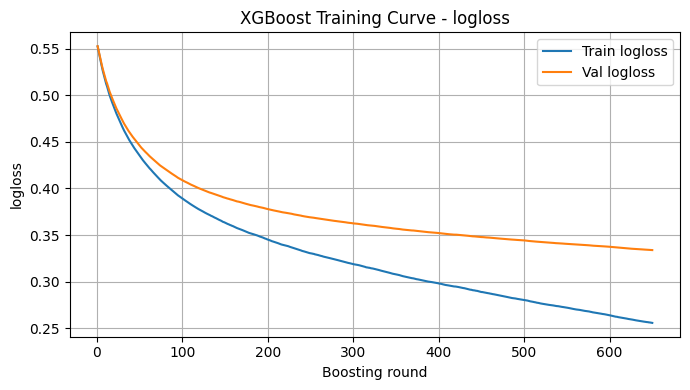

In [7]:
# XGBOOST TRAINING CURVES FOR best_model (XGBoost 2.x)

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

params = best_model.get_params()

# Ensure eval_metric + early_stopping_rounds are set in the constructor
params["eval_metric"] = "logloss"
params["early_stopping_rounds"] = 20  # patience for early stopping

# params["n_estimators"] = min(params["n_estimators"], 200)

# 2. Make a validation split from your training data
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42,
)

eval_set = [(X_tr, y_tr), (X_val, y_val)]

# 3. Rebuild the model with curve-friendly settings
model_for_curves = XGBClassifier(**params)

# 4. Fit with eval_set (NO early_stopping_rounds or eval_metric in .fit())
model_for_curves.fit(
    X_tr,
    y_tr,
    eval_set=eval_set,
    verbose=True,
)

# 5. Grab training history
results = model_for_curves.evals_result()

# 6. Plot function
def plot_training_curves(results, metric="logloss"):
    train_metric = results["validation_0"][metric]
    val_metric   = results["validation_1"][metric]
    rounds = range(1, len(train_metric) + 1)

    plt.figure(figsize=(7, 4))
    plt.plot(rounds, train_metric, label=f"Train {metric}")
    plt.plot(rounds, val_metric,   label=f"Val {metric}")
    plt.xlabel("Boosting round")
    plt.ylabel(metric)
    plt.title(f"XGBoost Training Curve - {metric}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 7. Plot logloss curve
plot_training_curves(results, metric="logloss")

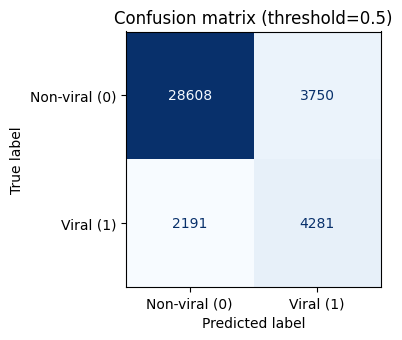

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion(y_true, y_pred, title="Confusion matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Non-viral (0)", "Viral (1)"]
    )
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, values_format='d', cmap="Blues", colorbar=False)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# usage (test set for a given threshold)
plot_confusion(y_test, y_test_pred, title="Confusion matrix (threshold=0.5)")

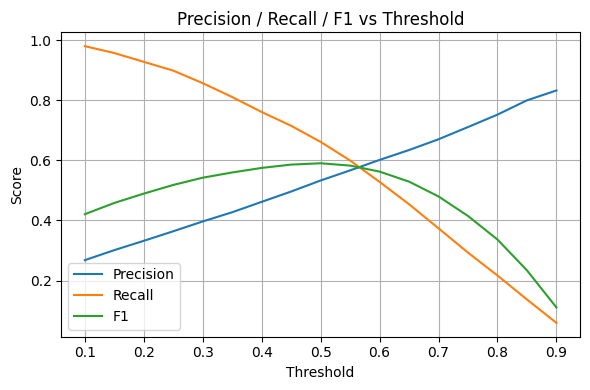

In [9]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def plot_metrics_vs_threshold(y_true, y_proba):
    thresholds = np.linspace(0.1, 0.9, 17)  # 0.10, 0.15, …, 0.90
    precisions = []
    recalls = []
    f1s = []

    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        precisions.append(precision_score(y_true, y_pred))
        recalls.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred))

    plt.figure(figsize=(6,4))
    plt.plot(thresholds, precisions, label="Precision")
    plt.plot(thresholds, recalls,   label="Recall")
    plt.plot(thresholds, f1s,       label="F1")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision / Recall / F1 vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# usage
y_test_proba = best_model.predict_proba(X_test)[:, 1]
plot_metrics_vs_threshold(y_test, y_test_proba)

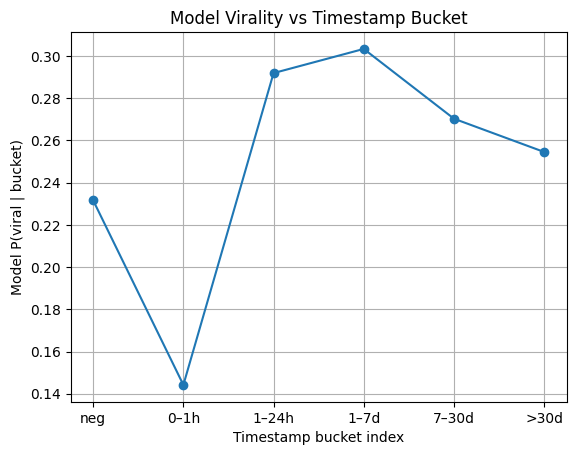

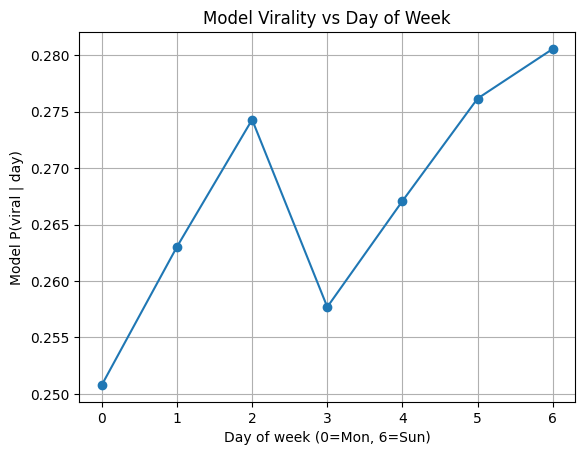

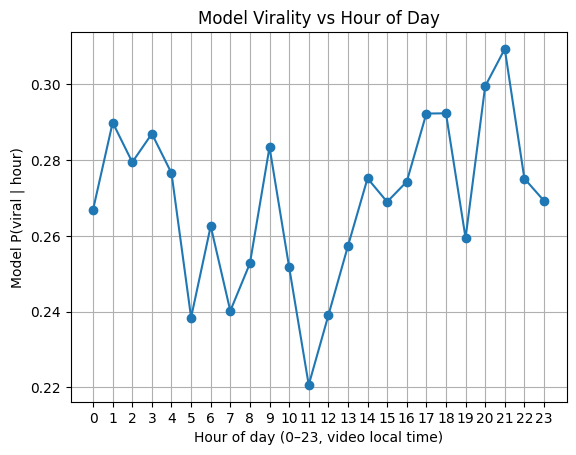

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Model-based P(viral | TIMESTAMP BUCKET)
# Unique bucket IDs (these come from np.digitize)
bin_ids = np.unique(X_train_bins)

bin_probs = []
for b in bin_ids:
    mask = (X_train_bins == b)
    if not np.any(mask):
        bin_probs.append(np.nan)
        continue
    # Use the *same feature representation* used to train the model
    p = best_model.predict_proba(X_train[mask])[:, 1].mean()
    bin_probs.append(p)

plt.figure()
plt.plot(bin_ids, bin_probs, marker='o')
plt.xlabel("Timestamp bucket index")
plt.ylabel("Model P(viral | bucket)")
plt.title("Model Virality vs Timestamp Bucket")
plt.grid(True)

# Optional: nicer x-axis labels if you know what each bin ID means:
bucket_labels = {
    1: "neg",     # negative timestamps (before premiere)
    2: "0–1h",
    3: "1–24h",
    4: "1–7d",
    5: "7–30d",
    6: ">30d"
}
xticks = [b for b in bin_ids if b in bucket_labels]
xtick_labels = [bucket_labels[b] for b in xticks]
plt.xticks(xticks, xtick_labels, rotation=0)

plt.show()

# Model-based P(viral | DAY OF WEEK)
# Days: 0=Mon .. 6=Sun (per datetime.weekday())
day_ids = np.arange(7)

day_probs = []
for d in day_ids:
    mask = (X_train_days_arr == d)
    if not np.any(mask):
        day_probs.append(np.nan)
        continue
    p = best_model.predict_proba(X_train[mask])[:, 1].mean()
    day_probs.append(p)

plt.figure()
plt.plot(day_ids, day_probs, marker='o')
plt.xlabel("Day of week (0=Mon, 6=Sun)")
plt.ylabel("Model P(viral | day)")
plt.title("Model Virality vs Day of Week")
plt.grid(True)
plt.xticks(day_ids)
plt.show()

# Model-based P(viral | HOUR OF DAY)
hour_ids = np.arange(24)

hour_probs = []
for h in hour_ids:
    mask = (X_train_hours_arr == h)
    if not np.any(mask):
        hour_probs.append(np.nan)
        continue
    p = best_model.predict_proba(X_train[mask])[:, 1].mean()
    hour_probs.append(p)

plt.figure()
plt.plot(hour_ids, hour_probs, marker='o')
plt.xlabel("Hour of day (0–23, video local time)")
plt.ylabel("Model P(viral | hour)")
plt.title("Model Virality vs Hour of Day")
plt.grid(True)
plt.xticks(hour_ids)
plt.show()

In [ ]:
# Save the best model to a file
best_model.save_model("best_model.json")
print("Saved best_model to best_model.json")

In [ ]:
from xgboost import XGBClassifier

loaded_model = XGBClassifier()
loaded_model.load_model("best_model.json")

# Example usage:
loaded_model.predict(X_test)

In [8]:
# Minimal SoftClusterMoE class (required before fast search)

import numpy as np
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, ClassifierMixin

class SoftClusterMoE(BaseEstimator, ClassifierMixin):
    """
    Soft Semantic-Cluster Mixture of Experts:
    - KMeans clustering
    - XGBoost expert per cluster
    - soft combination using distance-weighted probabilities
    """

    def __init__(
        self,
        n_clusters=6,
        alpha=1.0,
        random_state=42,
        # XGBoost expert hyperparameters
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=5,
        gamma=0.5,
        reg_lambda=1.0,
        reg_alpha=0.1,
        scale_pos_weight=1.0,
    ):
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.random_state = random_state

        # expert model params
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.min_child_weight = min_child_weight
        self.gamma = gamma
        self.reg_lambda = reg_lambda
        self.reg_alpha = reg_alpha
        self.scale_pos_weight = scale_pos_weight

    def _make_expert(self):
        return XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_jobs=-1,
            tree_method="hist",
            use_label_encoder=False,
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            learning_rate=self.learning_rate,
            subsample=self.subsample,
            colsample_bytree=self.colsample_bytree,
            min_child_weight=self.min_child_weight,
            gamma=self.gamma,
            reg_lambda=self.reg_lambda,
            reg_alpha=self.reg_alpha,
            scale_pos_weight=self.scale_pos_weight,
            random_state=self.random_state,
        )

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        # KMeans clustering
        self.kmeans_ = KMeans(
            n_clusters=self.n_clusters,
            random_state=self.random_state,
            n_init=10
        )
        cluster_labels = self.kmeans_.fit_predict(X)

        # Train one expert per cluster
        self.experts_ = []
        for c in range(self.n_clusters):
            mask = (cluster_labels == c)
            X_c, y_c = X[mask], y[mask]

            # fallback if cluster has 0 or 1 label type
            if X_c.shape[0] == 0 or len(np.unique(y_c)) < 2:
                X_c, y_c = X, y

            expert = self._make_expert()
            expert.fit(X_c, y_c)
            self.experts_.append(expert)

        return self

    def _expert_prob_matrix(self, X):
        X = np.asarray(X)
        return np.vstack([
            expert.predict_proba(X)[:, 1]
            for expert in self.experts_
        ]).T  # shape: (n_samples, n_clusters)

    def _weights(self, X):
        D = self.kmeans_.transform(np.asarray(X))   # distances to cluster centers
        W = np.exp(-self.alpha * (D ** 2))
        W_sum = W.sum(axis=1, keepdims=True)
        W_sum[W_sum == 0] = 1.0
        return W / W_sum

    def predict_proba(self, X):
        X = np.asarray(X)
        P = self._expert_prob_matrix(X)
        W = self._weights(X)
        p1 = np.sum(W * P, axis=1)
        p0 = 1.0 - p1
        return np.vstack([p0, p1]).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)


In [10]:
# Compute base_ratio (needed for scale_pos_weight)

y_train_np = np.asarray(y_train)

n_pos = np.sum(y_train_np == 1)
n_neg = np.sum(y_train_np == 0)

# ratio used for scale_pos_weight
base_ratio = n_neg / n_pos if n_pos > 0 else 1.0

print("Positive samples:", n_pos)
print("Negative samples:", n_neg)
print("base_ratio (neg/pos):", base_ratio)

Positive samples: 15100
Negative samples: 75502
base_ratio (neg/pos): 5.000132450331126


In [11]:
# FAST MoE SEARCH: Tune only MoE-level parameters

from sklearn.model_selection import RandomizedSearchCV

# Define a lightweight expert architecture
fast_moe = SoftClusterMoE(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=7,
    gamma=0.5,
    reg_lambda=2.0,
    reg_alpha=0.1,
    scale_pos_weight=base_ratio   # or base_ratio*0.75
)

# ONLY MoE parameters
fast_moe_param_dist = {
    "n_clusters": [4, 6, 8],
    "alpha":      [0.3, 0.7, 1.0, 1.5, 2.0],
}

moe_fast_search = RandomizedSearchCV(
    estimator=fast_moe,
    param_distributions=fast_moe_param_dist,
    n_iter=10,           # FAST
    scoring="f1",
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42,
)

print("\nRunning FAST RandomizedSearchCV for Soft MoE...\n")
moe_fast_search.fit(X_train, y_train)

best_moe = moe_fast_search.best_estimator_
print("\nBest FAST MoE params:", moe_fast_search.best_params_)


Running FAST RandomizedSearchCV for Soft MoE...

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:15:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:15:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:15:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:16:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:16:05] WARNING: /w


Best FAST MoE params: {'n_clusters': 6, 'alpha': 0.7}


In [12]:
# Soft Mixture-of-Experts Evaluation + Threshold Sweep

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix
)

print("\nFinal Soft MoE Evaluation Results")

# --- Probabilities ---
p_train = best_moe.predict_proba(X_train)[:, 1]
p_test  = best_moe.predict_proba(X_test)[:, 1]

# --- Default threshold ---
thr = 0.5
y_train_pred = (p_train >= thr).astype(int)
y_test_pred  = (p_test  >= thr).astype(int)

# -------------------------
# TRAIN METRICS
# -------------------------
print("TRAIN RESULTS (thr = 0.5)\n")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred, digits=3))

# -------------------------
# TEST METRICS
# -------------------------
print("TEST RESULTS (thr = 0.5)\n")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, digits=3))

print("\nConfusion Matrix (TEST):")
print(confusion_matrix(y_test, y_test_pred))


# ============================================================
# Threshold Sweep
# ============================================================

thresholds = [0.30, 0.35, 0.40, 0.45,
              0.50, 0.55, 0.60, 0.65, 0.70]

print("\nSoft MoE Threshold Sweep")

for thr in thresholds:
    y_pred_t = (p_test >= thr).astype(int)
    acc = accuracy_score(y_test, y_pred_t)
    bal = balanced_accuracy_score(y_test, y_pred_t)

    print(f"\n--- Threshold = {thr:.2f} ---")
    print("Accuracy:", acc)
    print("Balanced accuracy:", bal)
    print(classification_report(y_test, y_pred_t, digits=3))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred_t))



   Final Soft MoE Evaluation Results

============== TRAIN RESULTS (thr = 0.5) ==============

Accuracy: 0.8346283746495662
Balanced accuracy: 0.8291478494232247
              precision    recall  f1-score   support

           0      0.959     0.837     0.894     75502
           1      0.502     0.821     0.623     15100

    accuracy                          0.835     90602
   macro avg      0.731     0.829     0.759     90602
weighted avg      0.883     0.835     0.849     90602

=============== TEST RESULTS (thr = 0.5) ===============

Accuracy: 0.8021890291012104
Balanced accuracy: 0.7663572344348162
              precision    recall  f1-score   support

           0      0.935     0.820     0.874     32358
           1      0.442     0.713     0.546      6472

    accuracy                          0.802     38830
   macro avg      0.688     0.766     0.710     38830
weighted avg      0.852     0.802     0.819     38830


Confusion Matrix (TEST):
[[26537  5821]
 [ 1860  4612]]



Building 2D SVD projection of X_train for cluster visualization...


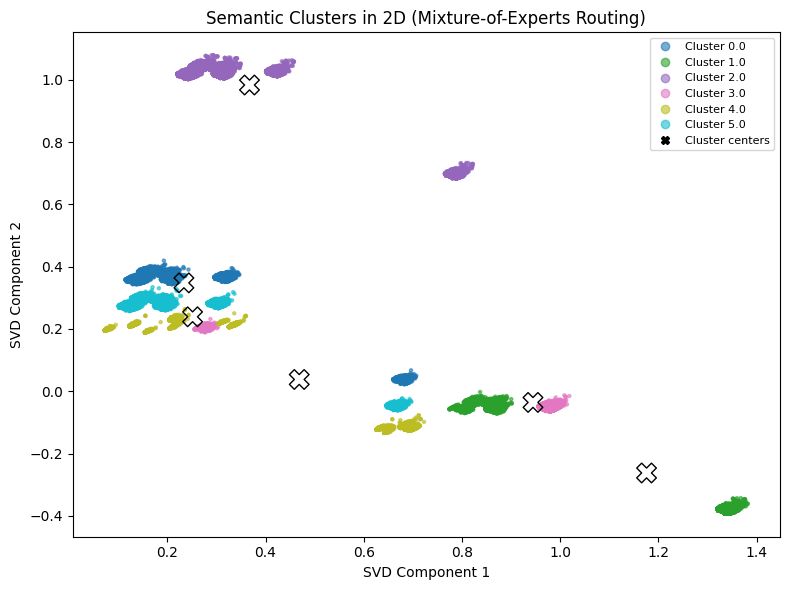

Building expert specialization heatmap over timestamp buckets...


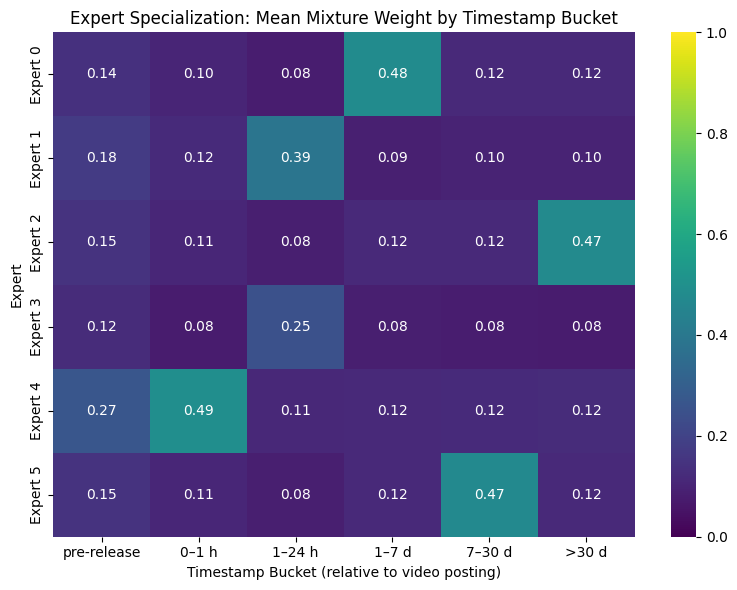


Sample counts per timestamp bucket (over all experts combined):
  pre-release: 1996 samples
  0–1 h     : 7777 samples
  1–24 h    : 34071 samples
  1–7 d     : 13389 samples
  7–30 d    : 9434 samples
  >30 d     : 23935 samples


In [15]:
# Cluster Map + Expert Specialization Heatmap

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import TruncatedSVD

# Safety checks / assumptions
# Assumes:
#   - best_moe: fitted SoftClusterMoE
#   - X_train: training features (same used to fit best_moe)
#   - y_train: training labels
#   - timestamps_train: 1D np.array aligned with X_train, in seconds

X_train_np = np.asarray(X_train)
y_train_np = np.asarray(y_train)

# Cluster Assignment Map (2D projection with TruncatedSVD)

print("Building 2D SVD projection of X_train for cluster visualization...")

# 2D projection (SVD works well for sparse/high-dim text)
svd = TruncatedSVD(n_components=2, random_state=42)
X_train_2d = svd.fit_transform(X_train_np)

# Cluster labels (these are the KMeans labels from best_moe)
cluster_labels = best_moe.kmeans_.labels_
n_clusters = best_moe.kmeans_.n_clusters

# Project cluster centers into same 2D space
centers_2d = svd.transform(best_moe.kmeans_.cluster_centers_)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_train_2d[:, 0],
    X_train_2d[:, 1],
    c=cluster_labels,
    cmap="tab10",
    s=5,
    alpha=0.6
)
plt.scatter(
    centers_2d[:, 0],
    centers_2d[:, 1],
    marker="X",
    s=200,
    edgecolor="k",
    linewidth=1.0,
    facecolors="none",
    label="Cluster centers"
)
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("Semantic Clusters in 2D (Mixture-of-Experts Routing)")
handles, labels = scatter.legend_elements(prop="colors", fmt="Cluster {x}")
plt.legend(handles + [plt.Line2D([], [], marker="X", linestyle="", color="k")],
           labels + ["Cluster centers"],
           loc="best", fontsize=8)
plt.tight_layout()
plt.show()

# Expert Weight × Timestamp-Bucket Heatmap
#    - rows: experts
#    - cols: timestamp buckets
#    - values: mean mixture weight for that expert in that bucket

print("Building expert specialization heatmap over timestamp buckets...")

# Define timestamp buckets (in seconds)
# Adjust if your notion of buckets differs
one_hour   = 60 * 60
one_day    = 24 * one_hour
one_week   = 7 * one_day
thirty_day = 30 * one_day

bins = np.array([
    -np.inf,        # pre-release
    0,              # 0
    one_hour,       # 0-1h
    one_day,        # 1-24h
    one_week,       # 1-7d
    thirty_day,     # 7-30d
    np.inf          # >30d
])

bucket_labels = [
    "pre-release",
    "0–1 h",
    "1–24 h",
    "1–7 d",
    "7–30 d",
    ">30 d"
]

timestamps_train_np = np.asarray(X_train_timestamps)

# Compute mixture weights W(x) for training samples
W_train = best_moe._weights(X_train_np)  # shape: (n_samples, n_experts)
n_experts = W_train.shape[1]
n_buckets = len(bucket_labels)

# Assign each sample to a timestamp bucket
bucket_ids = np.digitize(timestamps_train_np, bins) - 1  # 0..n_buckets-1

# Compute mean weight per (expert, bucket)
heatmap_data = np.zeros((n_experts, n_buckets), dtype=float)
heatmap_counts = np.zeros((n_experts, n_buckets), dtype=int)

for b in range(n_buckets):
    mask_b = bucket_ids == b
    if not np.any(mask_b):
        heatmap_data[:, b] = np.nan
        continue

    # weights for samples in this bucket: shape (num_samples_in_bucket, n_experts)
    W_b = W_train[mask_b, :]
    # mean weight per expert over this bucket
    heatmap_data[:, b] = W_b.mean(axis=0)
    heatmap_counts[:, b] = mask_b.sum()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    xticklabels=bucket_labels,
    yticklabels=[f"Expert {i}" for i in range(n_experts)],
    vmin=0.0,
    vmax=1.0
)
plt.xlabel("Timestamp Bucket (relative to video posting)")
plt.ylabel("Expert")
plt.title("Expert Specialization: Mean Mixture Weight by Timestamp Bucket")
plt.tight_layout()
plt.show()

# (Optional) If you want to see how many samples each bucket has:
print("\nSample counts per timestamp bucket (over all experts combined):")
for b_idx, label in enumerate(bucket_labels):
    count_b = np.sum(bucket_ids == b_idx)
    print(f"  {label:10s}: {count_b} samples")

In [ ]:
import joblib
import os

SAVE_DIR = "moe_model"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1. Save KMeans model
joblib.dump(kmeans, f"{SAVE_DIR}/kmeans.pkl")

# 2. Save each expert (as xgboost binary files)
for c in cluster_experts:
    cluster_experts[c].save_model(f"{SAVE_DIR}/expert_{c}.json")

# 3. Save metadata needed for inference
metadata = {
    "n_clusters": n_clusters,
    "svd_components": svd.n_components,
}
joblib.dump(metadata, f"{SAVE_DIR}/metadata.pkl")

print("Model saved to:", SAVE_DIR)